# Анализ твиттов на русском языке
корпус размеченных твиттов взят с сайта:
http://study.mokoron.com/

Пояснение к полям базы данных
База данных состоит из 12 столбцов:

- **id**: уникальный номер сообщения в системе twitter;
- **tdate**: дата публикации сообщения (твита);
- **tmane**: имя пользователя, опубликовавшего сообщение;
- **ttext**:  текст сообщения (твита);
- **ttype**: поле в котором в дальнейшем будет указано к кому классу относится твит (положительный, отрицательный, нейтральный);
- **trep**: количество реплаев к данному сообщению. В настоящий момент API твиттера не отдает эту информацию;
- **tfav**: число сколько раз данное сообщение было добавлено в избранное другими пользователями;
- **tstcount**: число всех сообщений пользователя в сети twitter;
- **tfol**: количество фоловеров пользователя (тех людей, которые читают пользователя);
- **tfrien**: количество друзей пользователя (те люди, которых читает пользователь);
- **listcount**: количество листов-подписок в которые добавлен твиттер-пользователь.

Загружаем необходимые библиотеки:

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import re
import pandas as pd

from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import roc_curve, auc

Считываем из корпуса только сами твитты и их эмоциональную окраску (колонки 'sentiment', 'tweet'): -1 = negative 1 = positive

In [22]:
df_pos = pd.read_csv('Data/RUS tweets/positive.csv', header=None, sep=';', usecols=[3,4], names=['tweet', 'sentiment'])
df_pos.head(3)

,tweet,sentiment
0,"@first_timee хоть я и школота, но поверь, у на...",1
1,"Да, все-таки он немного похож на него. Но мой ...",1
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1


In [23]:
df_neg = pd.read_csv('Data/RUS tweets/negative.csv', header=None, sep=';', usecols=[3,4], names=['tweet', 'sentiment'])
df_neg.head(3)

,tweet,sentiment
0,на работе был полный пиддес :| и так каждое за...,-1
1,"Коллеги сидят рубятся в Urban terror, а я из-з...",-1
2,@elina_4post как говорят обещаного три года жд...,-1


Смотрим сколько считали из файла твиттов.

In [25]:
df_pos.shape

(114911, 2)

In [26]:
df_neg.shape

(111923, 2)

Преобразуем твитты в отдельные списки для удобства дальнейшего анализа

In [27]:
positive_tweets = df_pos.tweet.tolist()
negative_tweets = df_neg.tweet.tolist()

Посмотрим содержимое списков

In [30]:
for i in range(3):
    print positive_tweets[i], '\n'

@first_timee хоть я и школота, но поверь, у нас то же самое :D общество профилирующий предмет типа) 

Да, все-таки он немного похож на него. Но мой мальчик все равно лучше:D 

RT @KatiaCheh: Ну ты идиотка) я испугалась за тебя!!! 



In [31]:
for i in range(3):
    print negative_tweets[i], '\n'

на работе был полный пиддес :| и так каждое закрытие месяца, я же свихнусь так D: 

Коллеги сидят рубятся в Urban terror, а я из-за долбанной винды не могу :( 

@elina_4post как говорят обещаного три года ждут...(( 



Проверим размеры полученых списков.

In [32]:
print len(positive_tweets)
print len(negative_tweets)

114911
111923


Удаляем из твиттов все ссылки, цифры, хэштеги, username и прочий мусор, который не нужен для анализа эмоциональной окраски

In [37]:
pos_clean = []
for s in positive_tweets:
    t = ""
    t = re.sub('(http\S+)', "", s)
    #t = re.sub('[^a-zA-z]', " ", t)
    t = re.sub('(#\w+)|(@\w+)|(\d+)|(&gt;)|(&lt;)', "", t)
    t = re.sub('^\s+', "", t)
    t = re.sub('\\n', " ", t)
    pos_clean.append(t)

In [39]:
neg_clean = []
for s in negative_tweets:
    t = ""
    t = re.sub('(http\S+)', "", s)
    #t = re.sub('[^a-zA-z]', " ", t)
    t = re.sub('(#\w+)|(@\w+)|(\d+)|(&gt;)|(&lt;)', "", t)
    t = re.sub('^\s+', "", t)
    t = re.sub('\\n', " ", t)
    neg_clean.append(t)

Объеденяем списки позитивных и негитивных твиттов в один:

In [41]:
tweets = pos_clean + neg_clean
len(tweets)

226834

Создаем список меток, где 1 - позитивные твитты, 0 - негативные

In [42]:
a = [1 for x in range(len(pos_clean))]
b = [0 for x in range(len(neg_clean))]
target = a + b

### TfidfVectorizer

Преобразуем текст твиттов в числовые векторы по алгоритму TF-IDF. Все параметры алгоритма оставляем по умолчанию. В дальнейшем будем подстраивать их для лучшей классификации

https://ru.wikipedia.org/wiki/TF-IDF

http://nlpx.net/archives/57

In [129]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),
                                   max_features=None)
tfidf_vectorizer.fit(tweets)

TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [130]:
tfidf = tfidf_vectorizer.transform(tweets)
tfidf

<226834x1238972 sparse matrix of type '<type 'numpy.float64'>'
	with 4210942 stored elements in Compressed Sparse Row format>

## Machine Learning

Классификацию твиттов будем проводить с помошью алгоритмов Наивный байесовский классификатор (Naive Bayes) и Логистическая регрессия (Logistic Regression)

Сначала разделим наш датасет на тренировочную и тестовую части

In [131]:
X_train, X_test, Y_train, Y_test = train_test_split(tfidf, target, test_size=0.25, random_state=1)
print(X_train.shape, X_test.shape)

((170125, 1238972), (56709, 1238972))


### Наивный байесовский классификатор (Naive Bayes)

Создаем объект и обучаем на тренеровочных данных первый алгоритм Naive Bayes

In [132]:
modelNB = MultinomialNB()
modelNB.fit(X_train, Y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Посмотрим как работает обученный алгоритм на тестовых данных

In [133]:
# Predicted outcomes
predicted = modelNB.predict(X_test)

# Actual Expected Outvomes
expected = Y_test

metrics.accuracy_score(expected, predicted)

0.75423654093706471

На тестовых данных получили точность классификации 77,4%

Для оценки работы обученного классификатора построим ROC-кривую.

ROC-кривая (Receiver Operator Characteristic) – кривая, которая наиболее часто используется для представления результатов бинарной классификации в машинном обучении. Поскольку классов два, один из них называется классом с положительными исходами, второй – с отрицательными исходами. ROC-кривая показывает зависимость количества верно классифицированных положительных примеров от количества неверно классифицированных отрицательных примеров. https://basegroup.ru/community/articles/logistic

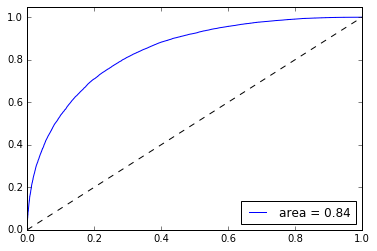

In [134]:
pred_probas = modelNB.predict_proba(X_test)[:,1]
fpr,tpr,roc_thresholds = roc_curve(Y_test, pred_probas)
roc_auc = auc(fpr,tpr)
plt.plot(fpr,tpr,label='area = %.2f' %roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc='lower right')

### Логистическая регрессия (Logistic Regression)

https://basegroup.ru/community/articles/logistic

Создаем объект и обучаем на тренеровочных данных второй алгоритм - Логистическая регрессия (Logistic Regression)

In [135]:
modelLR = LogisticRegression(C=5)
modelLR.fit(X_train, Y_train)

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Посмотрим как работает обученный алгоритм на тестовых данных

In [136]:
# Predicted outcomes
predicted = modelLR.predict(X_test)

# Actual Expected Outvomes
expected = Y_test

metrics.accuracy_score(expected, predicted)

0.76788516813909613

На тестовых данных получили точность классификации 80,3%. Т.е. этот алгоритм лучше классифицирует твитты, чем Наивный байесовский классификатор

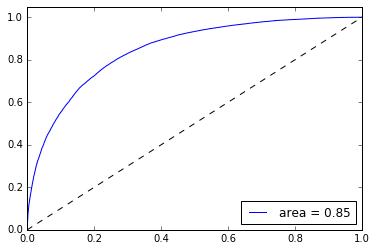

In [137]:
pred_probas = modelLR.predict_proba(X_test)[:,1]
fpr,tpr,roc_thresholds = roc_curve(Y_test, pred_probas)
roc_auc = auc(fpr,tpr)
plt.plot(fpr,tpr,label='area = %.2f' %roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc='lower right')

### Test LogisticRegression

In [138]:
example = ['Очень классный фильм']
X = tfidf_vectorizer.transform(example)
X

<1x1238972 sparse matrix of type '<type 'numpy.float64'>'
	with 5 stored elements in Compressed Sparse Row format>

In [139]:
p = modelLR.predict_proba(X)[0]
print "Probability:"
print " - Negative: %.2f%%" % (p[0]*100)
print " - Positive: %.2f%%" % (p[1]*100)

Probability:
 - Negative: 13.54%
 - Positive: 86.46%


## Сохраняем обученную модель

In [140]:
import pickle

In [141]:
pickle.dump(modelLR, open('RusTweetLogisticRegression.pkl', 'wb'), protocol=2)
pickle.dump(tfidf_vectorizer, open('RusTweetTfidfVectorizer.pkl', 'wb'), protocol=2)

## Загрузка и тестирование обученной модели

In [1]:
import pickle

In [2]:
modelLR = pickle.load(open('RusTweetLogisticRegression.pkl', 'rb'))
tfidf_vectorizer = pickle.load(open('RusTweetTfidfVectorizer.pkl', 'rb'))

In [3]:
example = ['Очень классный фильм']
X = tfidf_vectorizer.transform(example)
X

<1x1238972 sparse matrix of type '<type 'numpy.float64'>'
	with 5 stored elements in Compressed Sparse Row format>

In [4]:
p = modelLR.predict_proba(X)[0]
print "Probability:"
print " - Negative: %.2f%%" % (p[0]*100)
print " - Positive: %.2f%%" % (p[1]*100)

Probability:
 - Negative: 13.54%
 - Positive: 86.46%
